# Business Analytics
## Optimization Analytics: Pharmaceutical Detailing
(C) 2021

In [1]:
from IPython.display import HTML, display

def optional_material():
    '''
    When run in a cell, this function will color the cell blue to indicate
    the material is optional
    '''
    script =  "var cell = this.closest('.code_cell');"
    script += "var editor = cell.querySelector('.input_area');"
    script += "editor.style.background='#bde4f0';"
    script += "this.parentNode.removeChild(this)"
    
    display(HTML(f'<img src onerror="{script}">'))
    
optional_material()

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:900px !important; }</style>"))

In [2]:
currency_format = lambda x : '${:,.2f}'.format(x)

# GammaSoft

In [3]:
import pandas as pd

df_leads = pd.read_excel('/Users/gujiajun/Downloads/GammaSoft data.xlsx', sheet_name='Leads').set_index('LeadID')
df_reps = pd.read_excel('/Users/gujiajun/Downloads/GammaSoft data.xlsx', sheet_name='Reps').set_index('RepID')
df_interactions = pd.read_excel('/Users/gujiajun/Downloads/GammaSoft data.xlsx',
                                  sheet_name='Past interactions',
                                  skiprows=1).set_index('RepID')

In [4]:
df_leads.head(2)

,EXT,PAST_USE,Size
LeadID,,,
0,1,0.122,1966
1,1,0.381,3012


In [5]:
df_reps.head(2)

,SER,Capacity
RepID,,
0,1.35,2
1,1.20,2


In [6]:
df_interactions.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
RepID,,,,,,,,,,,,,,,,,,,,
0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0
1,1,0,0,1,0,1,0,0,0,0,1,0,1,1,0,1,1,0,0,0


In [7]:
# Logistic regression coefficients
const    = -3.07
ext      = -0.18
past_use = 0.05
ser      = 0.42
f2f      = 0.17

In [8]:
import numpy as np

revenues = np.zeros((len(df_reps), len(df_leads)))

for rep in df_reps.index:
    for lead in df_leads.index:
        w = ( const + ext*df_leads.loc[lead, 'EXT']
                         + past_use*df_leads.loc[lead, 'PAST_USE']
                         + ser*df_reps.loc[rep, 'SER']
                         + f2f*df_interactions.loc[rep, lead] )
        
        prob = 1/(1+np.exp(-w))
        
        revenues[rep,lead] = prob * df_leads.loc[lead, 'Size'] * 50

In [9]:
pd.DataFrame(revenues)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,6325.631875,9809.240165,7870.832189,10621.488401,6142.096221,8920.875384,8273.704431,12885.883880,3138.986939,5089.431617,7496.945924,9971.784242,6436.473227,8747.227190,5844.580466,7809.786464,2080.869436,8370.382916,9333.476195,3511.313881
1,6989.219292,9247.096628,7419.710431,10028.207830,5789.721754,9842.605011,7804.913089,12156.215755,2959.036481,4800.888641,8283.638347,8049.623176,7101.365877,9651.272321,5513.449289,7366.724351,2295.888023,6756.481162,8798.304738,3312.516159
2,5232.182266,8114.789096,6511.053966,7535.875807,5962.920116,8664.172123,6858.685177,10683.258320,3047.487398,4218.545143,6200.740513,7074.267103,5336.645987,8495.457672,5676.268881,5514.386903,2020.986975,5937.622104,7720.434311,3410.268530
3,5088.442162,7892.007452,7433.652881,7331.139474,4940.489746,7195.330629,7819.411397,12178.783010,2964.597994,4809.812095,6030.355795,8064.566636,5191.674623,7054.918682,4713.348309,5362.862285,1678.347785,5776.235893,7508.380185,3318.664654
4,6287.858438,8310.452410,7823.863773,9035.616099,5202.699344,7572.679031,8224.926726,10938.093371,2659.219784,4319.283543,6350.392009,8482.518635,5463.899650,7424.984429,5810.126432,5647.473267,1766.371709,6079.288578,7906.680540,2980.630816


## Heuristic 1; works the reps one by one

In [10]:
allocation = np.zeros((len(df_reps), len(df_leads)))

In [11]:
for rep in df_reps.index:
    these_leads = [(lead, revenues[rep, lead]) for lead in df_leads.index]
    these_leads = sorted(these_leads, key = lambda x : -x[1])
    
    for lead, _ in these_leads:
        if ((allocation[:, lead].sum() < 1)
                and (allocation[rep, :].sum() < df_reps.loc[rep, 'Capacity'])):
            allocation[rep, lead] = 1

In [12]:
heuristic_1 = (allocation*revenues).sum()
currency_format(heuristic_1)

'$105,371.43'

## Heuristic 2; works the leads one by one

In [13]:
allocation = np.zeros((len(df_reps), len(df_leads)))

In [14]:
for lead in df_leads.index:
    these_reps = [(rep, revenues[rep, lead]) for rep in df_reps.index]
    these_reps = sorted(these_reps, key = lambda x : -x[1])
    
    for rep, _ in these_reps:
        if ((allocation[:, lead].sum() < 1)
                and (allocation[rep, :].sum() < df_reps.loc[rep, 'Capacity'])):
            allocation[rep, lead] = 1

In [15]:
heuristic_2 = (allocation*revenues).sum()
currency_format(heuristic_2)

'$97,610.19'

## Heuristic 3; go with the highest combinations first

In [16]:
allocation = np.zeros((len(df_reps), len(df_leads)))

In [17]:
revenues_list = [(rep, lead, revenues[rep,lead])
                         for rep in df_reps.index for lead in df_leads.index]
revenues_list = sorted(revenues_list, key = lambda x : -x[2])

In [18]:
for rep, lead, _ in revenues_list:
    if ((allocation[:, lead].sum() < 1)
            and (allocation[rep, :].sum() < df_reps.loc[rep, 'Capacity'])):
        allocation[rep, lead] = 1

In [19]:
heuristic_3 = (allocation*revenues).sum()
currency_format(heuristic_3)

'$106,475.99'

# Linear Programming in Python

In [20]:
pip install pulp


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [21]:
pip install pulp --upgrade


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [37]:
# Create the PuLP LP
import pulp as pl

# Create the PuLP LP

m = pl.LpProblem('XGen', pl.LpMaximize)

In [25]:
# Create the variables
x = []

for i in df_reps.index:
    x.append([])
    
    for j in df_leads.index:
        x[i].append( pl.LpVariable(f'x_{i}_{j}', cat='Binary') )

x = np.array(x)

In [26]:
# Create the constraints

for j in df_leads.index:
    m += (pl.lpSum(x[:, j]) <= 1, f'lead_{j}_constraint')
    
for i in df_reps.index:
    m += (pl.lpSum(x[i, :]) <= df_reps.loc[i, 'Capacity'], f'rep_{i}_constraint')

In [27]:
# Create the objective
m += pl.lpSum(revenues*x)

In [28]:
pl.list_solvers(onlyAvailable=True)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-14
No parameters matching '_test' found


['GUROBI', 'GUROBI_CMD', 'PULP_CBC_CMD']

In [29]:
pl.PULP_CBC_CMD().solve(m)

1

### Extracting the solution

In [30]:
optimal_soln = m.objective.value()
currency_format(optimal_soln)

'$110,034.97'

In [31]:
for i in df_reps.index:
    print(f'Representative {i}:')
    
    for j in df_leads.index:
        if x[i,j].value() == 1:
            print(f'  - Lead {j}')
    
    print('')

Representative 0:
  - Lead 3
  - Lead 17

Representative 1:
  - Lead 10
  - Lead 15

Representative 2:
  - Lead 5
  - Lead 13
  - Lead 18

Representative 3:
  - Lead 2
  - Lead 6
  - Lead 7

Representative 4:
  - Lead 0
  - Lead 1
  - Lead 11



### Unsuccessful LPs

In [32]:
m = pl.LpProblem('unbounded', pl.LpMaximize)
x1 = pl.LpVariable('x1', cat='Continuous')
m += x1
pl.PULP_CBC_CMD().solve(m)

-2

In [33]:
m = pl.LpProblem('infeasible', pl.LpMaximize)
x2 = pl.LpVariable('x2', cat='Continuous')
m += (x2 >= 5)
m += (x2 <= 4)
m += x2
pl.PULP_CBC_CMD().solve(m)

-1

# Managerial insights

In [34]:
# Create the basic LP again

m = pl.LpProblem('XGen', pl.LpMaximize)
x = np.array([[pl.LpVariable(f'x_{i}_{j}', cat='Binary')
                       for j in df_leads.index] for i in df_reps.index])

for j in df_leads.index:
    m += (pl.lpSum(x[:, j]) <= 1, f'lead_{j}_constraint')
    
for i in df_reps.index:
    m += (pl.lpSum(x[i, :]) <= df_reps.loc[i, 'Capacity'], f'rep_{i}_constraint')

m += pl.lpSum(revenues*x)
pl.PULP_CBC_CMD().solve(m)

1

In [35]:
# Alter rep 1's capacity from 1 to 12, and re-solve the LP
# in each case
opt_revenues = []

extra_capacity_cost = 5000

for rep_1_cap in range(2, 13):
    m.constraints['rep_1_constraint'] = (pl.lpSum(x[1, :]) <= rep_1_cap)
    pl.PULP_CBC_CMD().solve(m)
    opt_revenues.append(m.objective.value() - extra_capacity_cost*(rep_1_cap - 2))

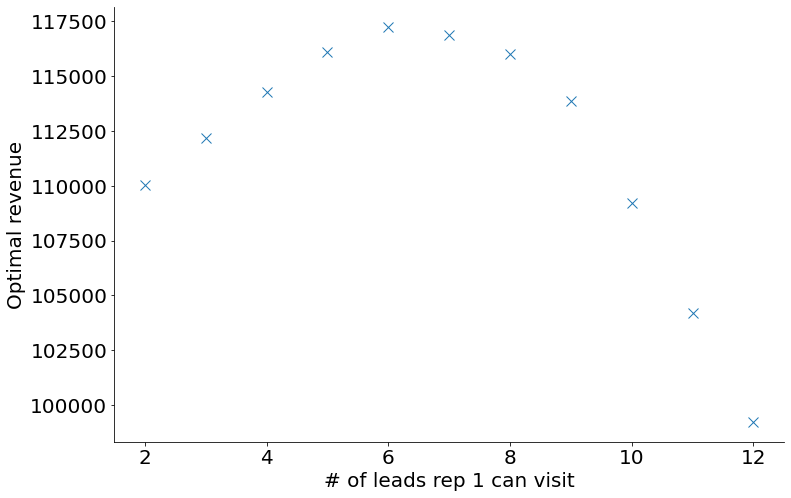

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))

plt.plot(range(2, 13), opt_revenues, linewidth=0, marker='x', markersize=10)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlabel('# of leads rep 1 can visit', fontsize=20)
plt.ylabel('Optimal revenue', fontsize=20)

sns.despine()